In [1]:
!mkdir /content/data
!mkdir /content/sample_image

### OpenCV Darknet Yolo를 이용하여 이미지Object Detection
* yolo를 이용하여 Object Detection

#### Darknet Yolo사이트에서 coco로 학습된 Inference모델와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

* https://pjreddie.com/darknet/yolo/ 에 다운로드 URL 있음.
* pretrained 모델은 wget https://pjreddie.com/media/files/yolov3.weights 에서 다운로드
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg 에서 다운로드
* wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg
* readNetFromDarknet(config파일, weight파일)로 config파일 인자가 weight파일 인자보다 먼저 옴. 주의 필요. 

* tiny yolo의 pretrained된 weight파일은 wget https://pjreddie.com/media/files/yolov3-tiny.weights 에서 download 가능. 
* config 파일은 wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg 로 다운로드

In [1]:
### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드하여 /content/pretrained 디렉토리 아래에 저장. 
!mkdir ./pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true 

!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

!ls /content/pretrained


##### downloading pretrained yolo/tiny-yolo weight file and config file
--2023-06-06 14:11:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/pretrained/yolov3.weights’

/content/pretrained 100%[===================>] 236.52M  39.8MB/s    in 6.4s    

2023-06-06 14:11:12 (37.1 MB/s) - ‘/content/pretrained/yolov3.weights’ saved [248007048/248007048]

--2023-06-06 14:11:13--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2023-06-06 14:11:13--  https://github.com/p

#### Google Drive 접근을 위한 Mount

In [2]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# # Google Drive 밑에 crop_Directory 생성.
# !mkdir "/MyDrive/cropped_images"

Mounted at /content/gdrive
'Backup 2023-04-13.zip'   cropped_images   raw_images	  ultra_workdir
'Colab Notebooks'	  LP_data	   sample_image  '제목 없는 문서.gdoc'


#### COCO class id와 class 명 매핑

In [3]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

#### readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

In [4]:
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'

# darknet yolo pretrained 모델 로딩. config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    


#### 단일 이미지를 Yolo로 detect하는 get_detected_img() 함수 생성. 

In [14]:
def get_detected_img(cv_net, image_file, img_array, conf_threshold, nms_threshold, is_print=True):
    # 3개의 scale Output layer에서 결과 데이터 추출
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()

    # opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]
    #print('output_layer name:', outlayer_names)
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)

    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []
    cropped_images_list = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold:
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)

                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                # class_id가 2,5,7인 경우(car,bus,truck)에 대해서만 Detect된 Object의 정보를 수집함
                if class_id == 2 or 5 or 7:
                  class_ids.append(class_id)
                  confidences.append(float(confidence))
                  boxes.append([left, top, width, height])
    
    # NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외. 
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    print("idxs : ",idxs)

    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
      

            # ------------------------- 자동차 검출 되나 test ------------------------------------- #
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
            # ------------------------- 자동차 검출 되나 test ------------------------------------- #


            # # NMS 통과한 이미지 crop및 저장.
            # cropped_image = img_array[top : (top + height) , left: (left + width)]        
            # save_path = os.path.join('/content/gdrive/MyDrive/cropped_images/', str(i) + image_file)
            # cv2.imwrite(save_path, cropped_image)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

### Object Detetion & image_crop 수행

REC_2023_05_29_18_20_31_F.MP4_20230606232749_0001.JPEG
idxs :  [11  1  6  0  3  4  2]
Detection 수행시간: 2.27 초


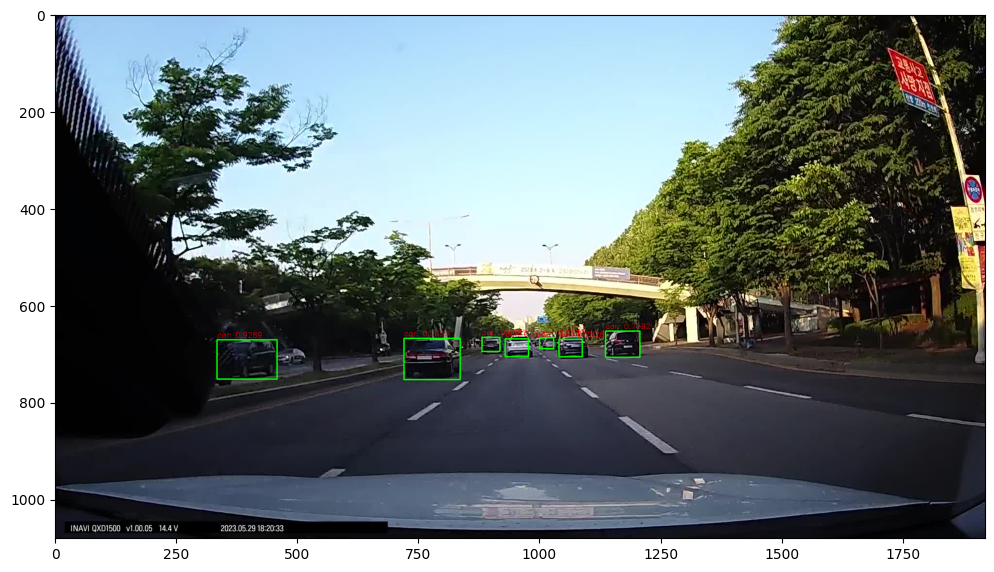

In [17]:
conf_threshold = 0.6
nms_threshold = 0.5

folder_path = '/content/gdrive/MyDrive/sample_image/'
image_files = os.listdir(folder_path)

# 이미지 파일 경로들을 가져와서 처리
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    img = cv2.imread(image_path)
    # save_path = os.path.join('/content/gdrive/MyDrive/cropped_images', image_file)
    # cv2.imwrite(save_path, img)
    
    print(image_file)
    

    # # Object Detetion 수행 후 시각화, get_detected_img() 함수로 이미지에서 자동차 부분을 crop 후 저장
    draw_img = get_detected_img(cv_net_yolo, image_file, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

    # 그리는거 테스트
    img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(img_rgb)